In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud as wc

from string import punctuation as p
from collections import Counter as cnt 
from nltk.tokenize import word_tokenize as wt
from nltk.stem import WordNetLemmatizer as lemma
from nltk.corpus import stopwords
from gensim import corpora
from nltk.sentiment.vader import SentimentIntensityAnalyzer



from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split,GridSearchCV as gsv
from sklearn.metrics import accuracy_score,classification_report,f1_score,auc,roc_curve,\
confusion_matrix,log_loss,precision_score,recall_score,mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
#importing training file
train=pd.read_csv(r"C:\Users\mishr\fr_projects\hotel\train.csv")

In [3]:
train.head(4)

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy


In [4]:
train.shape

(38932, 5)

In [5]:
#null value checking
train.isnull().sum()

User_ID         0
Description     0
Browser_Used    0
Device_Used     0
Is_Response     0
dtype: int64

In [6]:
#renaming the coulumn
train.rename(columns={"Is_Response":'response'},inplace=True)

In [7]:
#checking unique values in response column and their count
u_val=train['response'].nunique()
vc=train['response'].value_counts()
print('In',train.columns.values[-1].upper(),'there are',u_val,'unique values.Their counts are\n',vc)

In RESPONSE there are 2 unique values.Their counts are
 happy        26521
not happy    12411
Name: response, dtype: int64


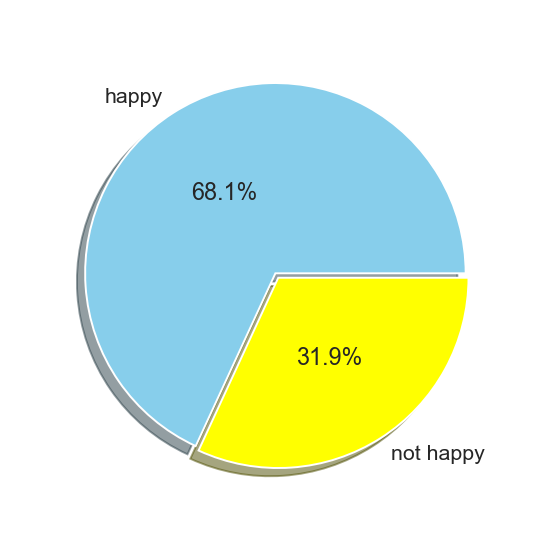

In [8]:
lb=train['response'].value_counts().index.tolist()
val=train['response'].value_counts().values.tolist()
exp=(0.025,0)
clr=('skyblue','yellow')
plt.figure(figsize=(10,5),dpi=140)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
plt.pie(x=val,explode=exp,labels=lb,colors=clr,autopct='%2.1f%%',pctdistance=0.5, shadow=True,radius=0.9)
plt.show()

In [9]:
train.describe()

,User_ID,Description,Browser_Used,Device_Used,response
count,38932,38932,38932,38932,38932
unique,38932,38932,11,3,2
top,id48967,We just returned from a - night stay (Oct. ---...,Firefox,Desktop,happy
freq,1,1,7367,15026,26521



**PREPROCESSING**



In [10]:
#DROPPING UNWANTED
train.drop(['User_ID','Browser_Used','Device_Used'],axis=1,inplace=True)#

In [11]:
#CREATING A COLUMN TO CHECK THE LENGTH OF EACH ROW OF DESCRIPTION COLUMN
train['len_uncleaned desc']=train['Description'].str.len()
train.head(3)

,Description,response,len_uncleaned desc
0,The room was kind of clean but had a VERY stro...,not happy,248
1,I stayed at the Crown Plaza April -- - April -...,not happy,1077
2,I booked this hotel through Hotwire at the low...,not happy,1327


In [12]:
#LABEL ENCODING USING MAP FUNCTION
remap={'happy':1,'not happy':0}
train['response']=train['response'].map(remap)

In [13]:
#CONVRTING EVERYTHING TO LOWERCASE
train['Description']=train['Description'].str.lower()

#REPLACING NEXT LINES BY WHITE SPACE
train['Description']=train['Description'].str.replace(r'\n'," ") 

#REPLACING SPECIAL CHARACTERS AND NUMBERS BY WHITE SPACE IT ALSO REMOVES THE PUNCTUATIONS
train['Description']=train['Description'].str.replace(r"[^a-zA-Z]+", " ") #removing all special characters

In [14]:
#PREVIEW AFTER LOWER CASE CONVERSION AND REMOVAL OF UNWANTED CHARACTERS
print(train['Description'][2:8])

2    i booked this hotel through hotwire at the low...
3    stayed here with husband and sons on the way t...
4    my girlfriends and i stayed here to celebrate ...
5    we had rooms one was very nice and clearly had...
6    my husband and i have stayed in this hotel a f...
7    my wife i stayed in this glorious city a while...
Name: Description, dtype: object


In [15]:
#CREATING A FUNCTION FOR REMOVING STOPWORDS, PUNCTUATION MARKS AND  CREATING WORD TOKEN AND LEMMATIZING THEM
def clean(text):
    cleaned=[]
    for i in wt(text):
        if i not in p:
            if not i in stopwords.words('english') and len(i)>=2:
                cleaned.append(lemma().lemmatize(i,pos='v')) 
    return (" ".join([x for x in cleaned])).strip()
                

In [16]:
#TESTING THE FUNCTION
text="But look! here come more crowds, pacing straight for the water, and seemingly bound for a dive. Strange! Nothing\
will content them but theextremest limit of the land; loitering under the shady lee of yonderwarehouses will not suffice.\
No. They must get just as nigh the water asthey possibly can without falling And there they stand- miles of them-leagues. \
Inlanders all, they come from lanes and alleys, streets avenues-north, east, south, and west. Yet here they all unite. \
Tell me, does themagnetic virtue of the needles of the compasses of all those ships attractthem thither?"
text=text.lower()
print(clean(text))

look come crowd pace straight water seemingly bind dive strange nothingwill content theextremest limit land loiter shady lee yonderwarehouses suffice.no must get nigh water asthey possibly without fall stand- miles them-leagues inlanders come lanes alleys streets avenues-north east south west yet unite tell themagnetic virtue needle compass ship attractthem thither


In [17]:
%%time
cleaned = []

for i in train['Description']:
    cleaned.append(clean(i))

Wall time: 47min 9s


In [18]:
print("Length of cleaned text=\t",len(cleaned))
print(cleaned[:3])

Length of cleaned text=	 38932
['room kind clean strong smell dog generally average ok overnight stay fussy would consider stay price right breakfast free better nothing', 'stay crown plaza april april staff friendly attentive elevators tiny food restaurant delicious price little high side course washington dc pool little children room fifth floor two comfortable bed plenty space one person tv little small todays standards limit number channel small bite mold bathtub area could remove little bleach appear carpet vacummed every day report light bulb burn never replace ice machine odd number floor one floor work encounter staff elevator one even mention ice machine severel hours later maid appear door ice two mint sure know room little unnerve would stay business would come vacation', 'book hotel hotwire lowest price could find get front desk manager give us smoke room argue little baby would book room know smoke manager would hear anything tell hotwire book cheapest room available get g

In [19]:
#ADDING THE EXTRACTED FEATURES TO THE DATAFRAME
processed = pd.DataFrame({'cleaned_description' : cleaned })
train = pd.concat([train, processed], axis = 1)
train['len_cleaned_description']=train['cleaned_description'].str.len()
train.sample(5)

,Description,response,len_uncleaned desc,cleaned_description,len_cleaned_description
8590,i hosted approximately clients at this hotel a...,0,606,host approximately clients hotel please result...,382
2302,this hotel was very nice the lobby the rooms a...,1,631,hotel nice lobby room location location fabulo...,370
13769,i booked this hotel for nights as a get away f...,0,1880,book hotel nights get away daughter spring bre...,952
27458,stayed in ny many times but first time in the ...,1,243,stay ny many time first time time square area ...,166
21552,i found the milburn through tripadvisor and ch...,0,817,find milburn tripadvisor choose review locatio...,473


In [20]:
#CALCULATING
print('Original Length = ', train['len_uncleaned desc'].sum())
print('Clean Length =  ', train['len_cleaned_description'].sum())
print('Total Reduction = ',train['len_uncleaned desc'].sum()-train['len_cleaned_description'].sum())

Original Length =  33725876
Clean Length =   19544373
Total Reduction =  14181503


**WORD CLOUDS TO CHECK HIGH FREQUENCY WORDS FOR HAPPY**

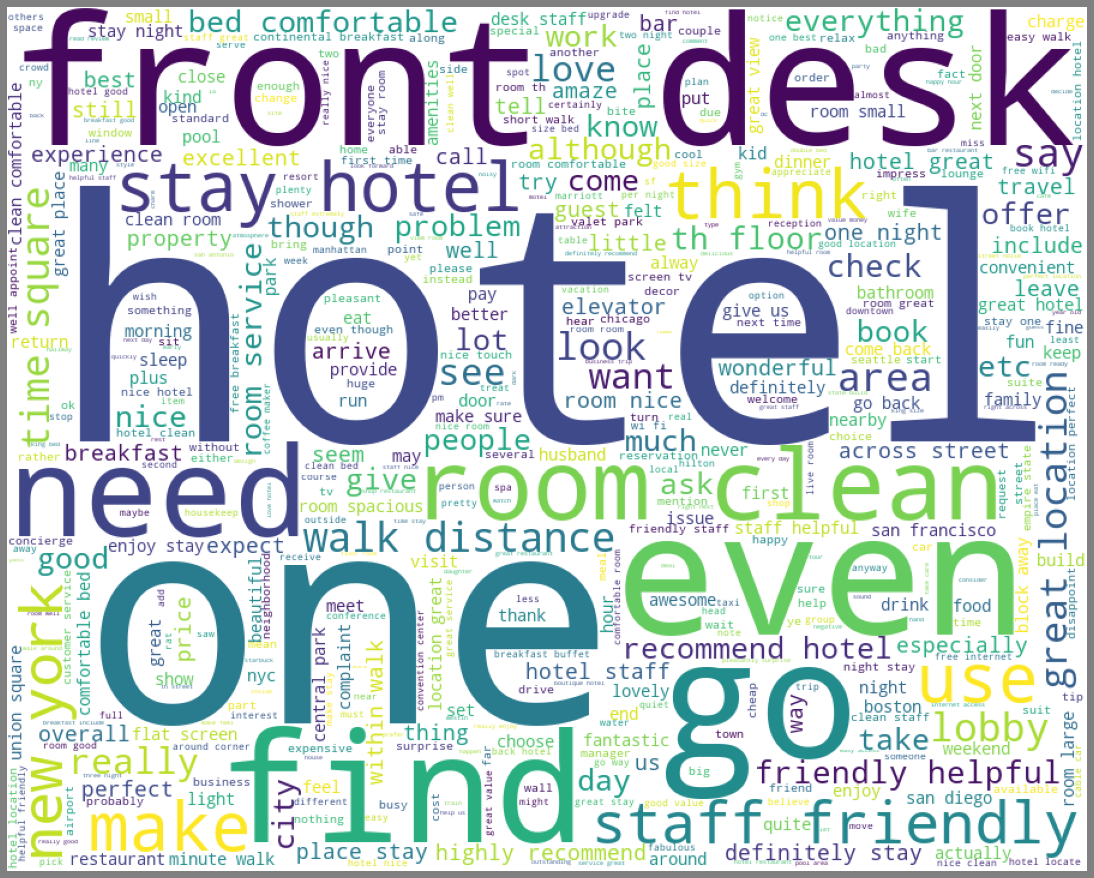

In [21]:
happy = train['cleaned_description'][train['response']==1]
happy_cloud = wc(width=900,height=720,background_color='white',max_words=500).generate(' '.join(happy))
plt.figure(figsize=(15,18),facecolor='grey')
plt.imshow(happy_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**WORD CLOUDS TO CHECK HIGH FREQUENCY WORDS FOR NOT HAPPY**

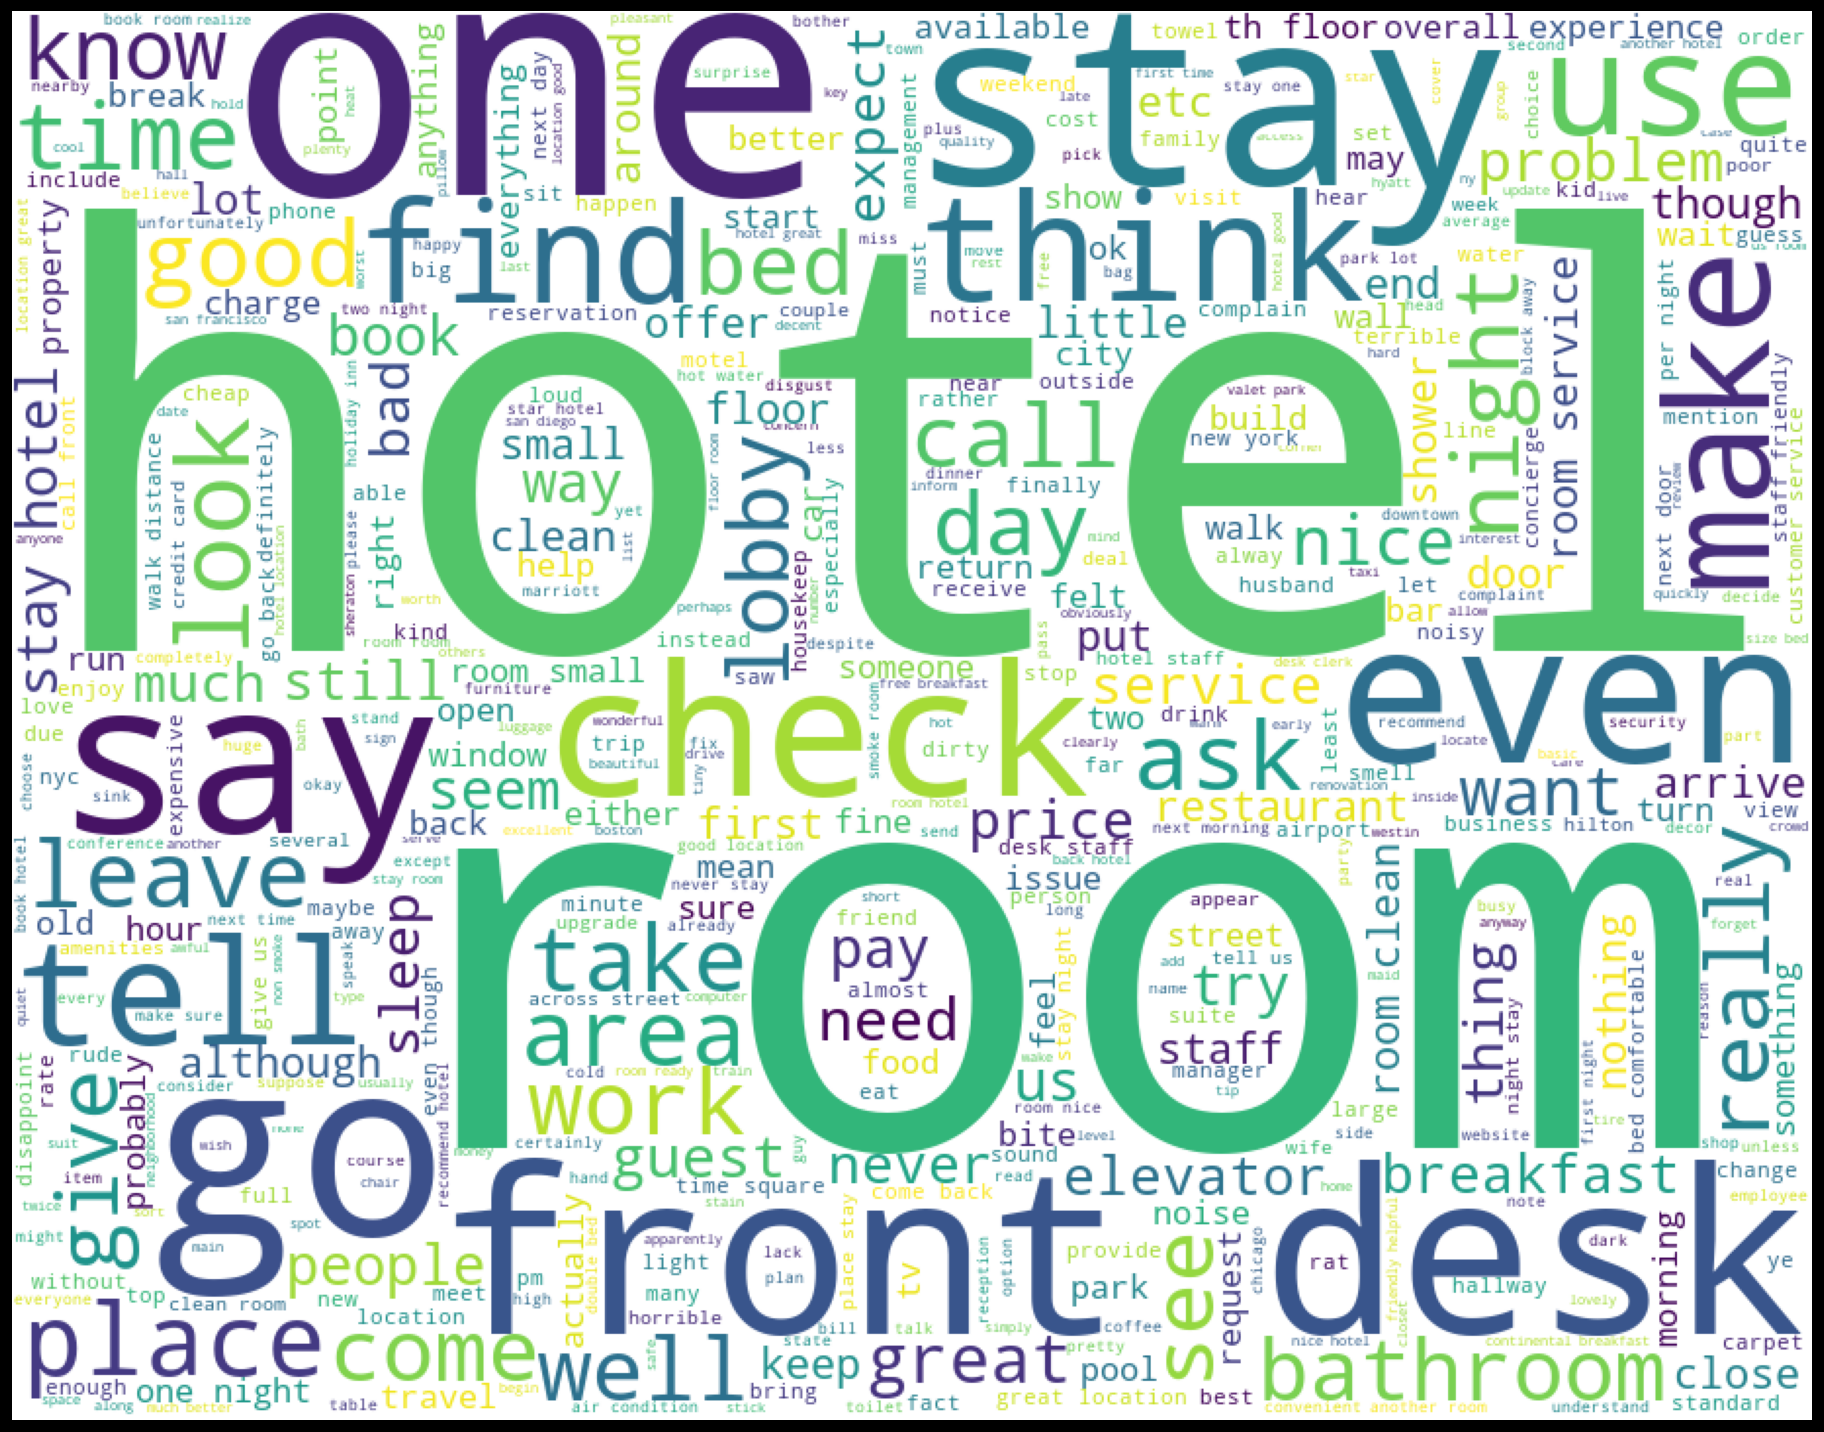

In [22]:
unhappy = train['cleaned_description'][train['response']==0]
unhappy_cloud = wc(width=920,height=720,background_color='white',max_words=500).generate(' '.join(unhappy))
plt.figure(figsize=(15,18),facecolor='black',dpi=120)
plt.imshow(unhappy_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**MODELING**

In [23]:
y=train['response']

x=tfidf(input='content', encoding='utf-8', lowercase=True,stop_words='english').fit_transform(train['cleaned_description'])
x

<38932x38774 sparse matrix of type '<class 'numpy.float64'>'
	with 2136756 stored elements in Compressed Sparse Row format>

In [24]:
ACCURACY = []
PRECISION = []
RECALL = []
RMSE = []
MSE = []
ROC_AUC=[]

def acusr(model,x,y):
    max_ac=0
    for rst in range(25,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=rst)
        model.fit(x_train,y_train)
        pred=model.predict(x_test)
        acc=accuracy_score(pred,y_test)
        clr=classification_report(y_test,pred)
        conf=confusion_matrix(y_test,pred)
        pre=precision_score(y_test,pred)
        rec=recall_score(y_test,pred)
        mse=mean_squared_error(y_test,pred)
        rmse=np.sqrt(mse)
        fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label = 1)
        roc_auc = auc(fpr, tpr)
        if acc>max_ac:
            max_ac=acc
            final_rst=rst
         
    print("In this",model,"\nRANDOM STATE:\n",final_rst)
    print('\nACCURACY SCORE:\n', max_ac)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nCONFUSION MATRIX:\n',conf)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)

    #ADDING VALUES TO LIST
    ACCURACY.append(acc)
    PRECISION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    ROC_AUC.append(roc_auc)
    
   
    #PLOTTING auc_roc CURVE
    sns.set(style='whitegrid',context='talk',font_scale=0.7)
    plt.figure(figsize=(8,7),dpi=120)
    plt.plot([0,1],[0,1],color='aquamarine',linestyle=":",lw=3)
    plt.plot(fpr,tpr,label="AUC= %0.2f" % roc_auc,color='dodgerblue',lw=3,linestyle='--')
    plt.legend(loc='lower right',fontsize='medium',shadow=True)
    plt.xlabel("FPR")
    plt.ylabel('TPR')
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE',size=15,weight='bold',loc='center')
    plt.show()
    
    
    #PLOTTING CONFUSION MATRIX
    plt.figure(figsize=(6,4),dpi=120)
    sns.heatmap(conf,annot=True,cmap='Blues')
    plt.title('HEATMAP OF CONFUSION MATRIX')
    plt.show()

**LOGISTIC REGRESSION**

In this LogisticRegression(max_iter=600, warm_start=True) 
RANDOM STATE:
 50

ACCURACY SCORE:
 0.8849315068493151

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80      3699
           1       0.89      0.94      0.91      7981

    accuracy                           0.88     11680
   macro avg       0.87      0.84      0.86     11680
weighted avg       0.88      0.88      0.88     11680


CONFUSION MATRIX:
 [[2763  936]
 [ 462 7519]]

PRECISION:
 0.8892962743938498

RECALL:
 0.9421125172284175

MEAN SQUARED ERROR:
 0.11969178082191781

ROOT MEAN SQ. ERROR:
 0.34596499941745235


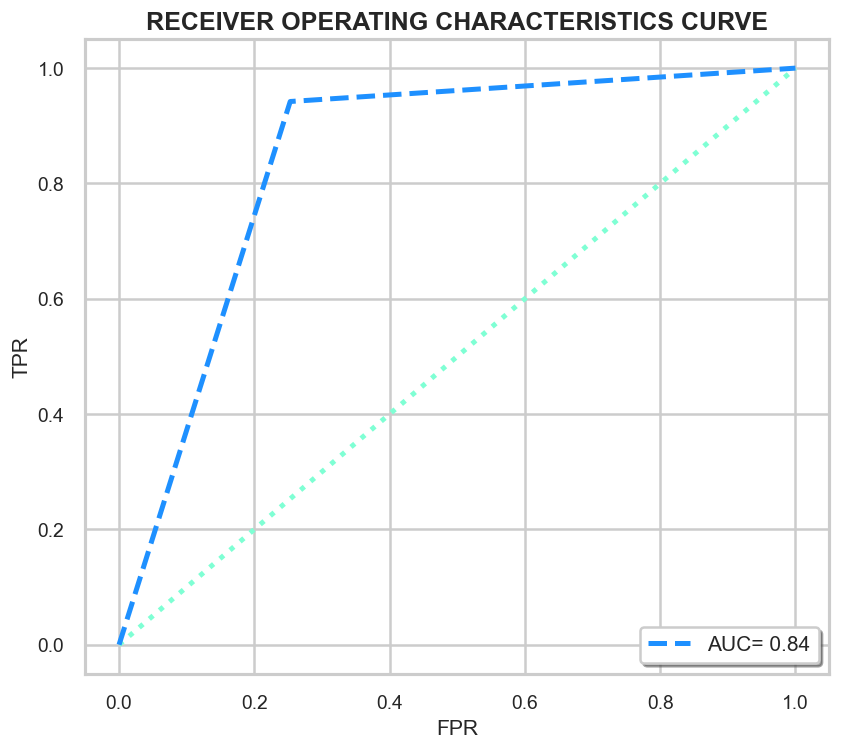

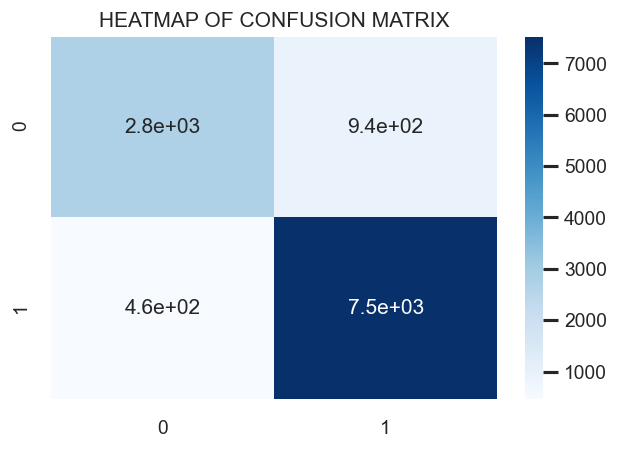

In [25]:
logi=LogisticRegression(max_iter=600,warm_start=True)
acusr(logi,x,y)

**MULTINIMIAL NB**

In [26]:
nb=MultinomialNB()
params = {'alpha': [0.1, 0.2, 0.8, 0.9, 1.0]}
mnb = gsv(nb,params,scoring='f1_weighted', cv=50)
mnb.fit(x,y)
print(mnb)
print('\nbest_score=',mnb.best_score_)
print('\nbest_parameters=',mnb.best_params_)


GridSearchCV(cv=50, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.2, 0.8, 0.9, 1.0]},
             scoring='f1_weighted')

best_score= 0.8526778657127513

best_parameters= {'alpha': 0.1}


In this MultinomialNB(alpha=0.1) 
RANDOM STATE:
 80

ACCURACY SCORE:
 0.8627568493150685

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.86      0.66      0.75      3699
           1       0.86      0.95      0.90      7981

    accuracy                           0.86     11680
   macro avg       0.86      0.81      0.83     11680
weighted avg       0.86      0.86      0.85     11680


CONFUSION MATRIX:
 [[2448 1251]
 [ 392 7589]]

PRECISION:
 0.8584841628959275

RECALL:
 0.9508833479513845

MEAN SQUARED ERROR:
 0.14066780821917807

ROOT MEAN SQ. ERROR:
 0.37505707328242466


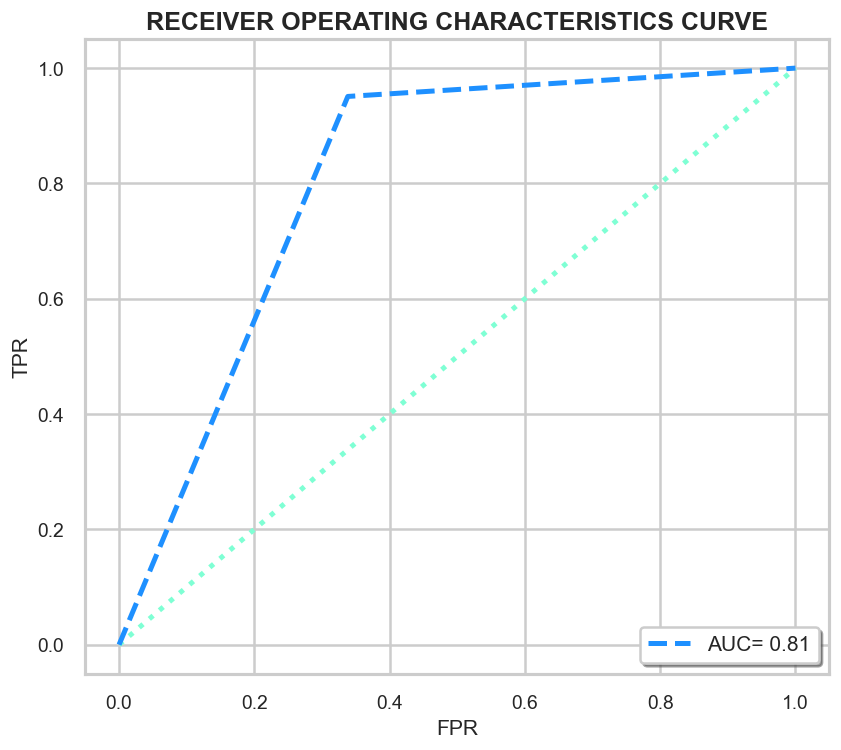

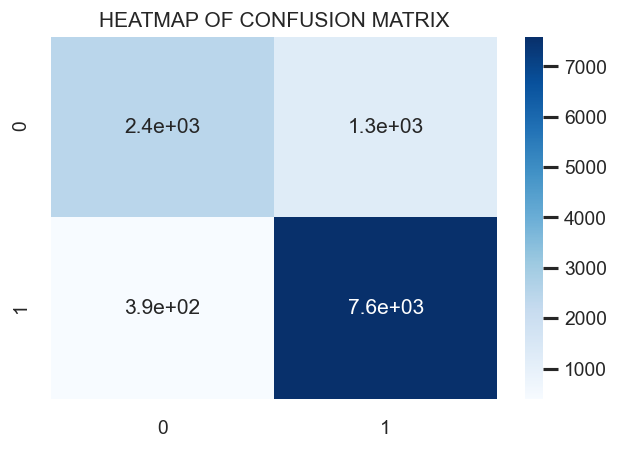

In [27]:
nb=MultinomialNB(alpha=0.1)
acusr(nb,x,y)

**COMPLEMENT NB**

In [30]:
NB_Params = {'alpha': [0.1,  0.9, 1.0]}

cnb = ComplementNB()
cnb_gsv = gsv(cnb, NB_Params, cv=20)
cnb_gsv.fit(x,y)
print(cnb_gsv)
print('\nbest_score=',cnb_gsv.best_score_)
print('\nbest_parameters=',cnb_gsv.best_params_)

GridSearchCV(cv=20, estimator=ComplementNB(),
             param_grid={'alpha': [0.1, 0.9, 1.0]})

best_score= 0.8602435902917552

best_parameters= {'alpha': 0.9}


In this ComplementNB(alpha=0.9) 
RANDOM STATE:
 80

ACCURACY SCORE:
 0.8619006849315068

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.88      0.62      0.73      3699
           1       0.85      0.96      0.90      7981

    accuracy                           0.85     11680
   macro avg       0.86      0.79      0.81     11680
weighted avg       0.86      0.85      0.85     11680


CONFUSION MATRIX:
 [[2300 1399]
 [ 312 7669]]

PRECISION:
 0.8457212174680194

RECALL:
 0.9609071544919183

MEAN SQUARED ERROR:
 0.14648972602739727

ROOT MEAN SQ. ERROR:
 0.382739762798951


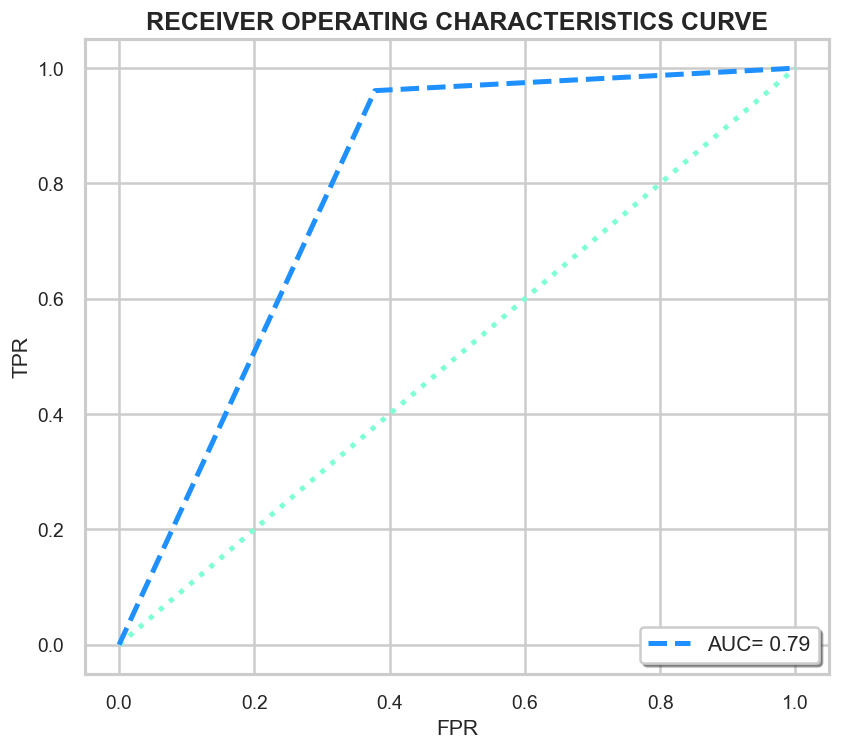

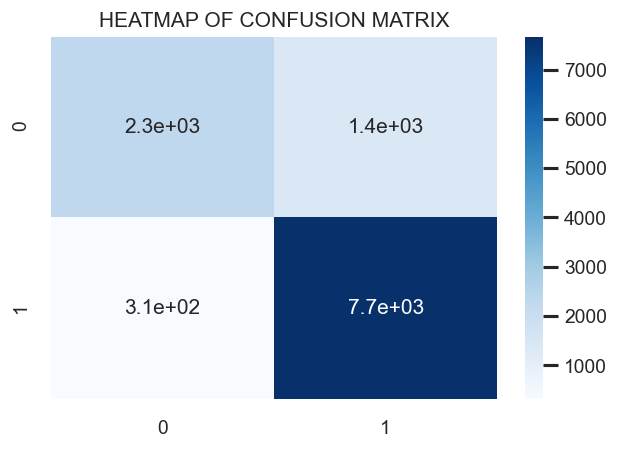

In [31]:
cnb = ComplementNB(alpha=0.9)
acusr(cnb,x,y)

**SVC**

In this SVC(degree=9, gamma=0.1, kernel='linear') 
RANDOM STATE:
 59

ACCURACY SCORE:
 0.8837328767123288

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      3699
           1       0.90      0.93      0.91      7981

    accuracy                           0.88     11680
   macro avg       0.86      0.85      0.86     11680
weighted avg       0.88      0.88      0.88     11680


CONFUSION MATRIX:
 [[2830  869]
 [ 562 7419]]

PRECISION:
 0.8951496138996139

RECALL:
 0.9295827590527502

MEAN SQUARED ERROR:
 0.12251712328767124

ROOT MEAN SQ. ERROR:
 0.35002446098475926


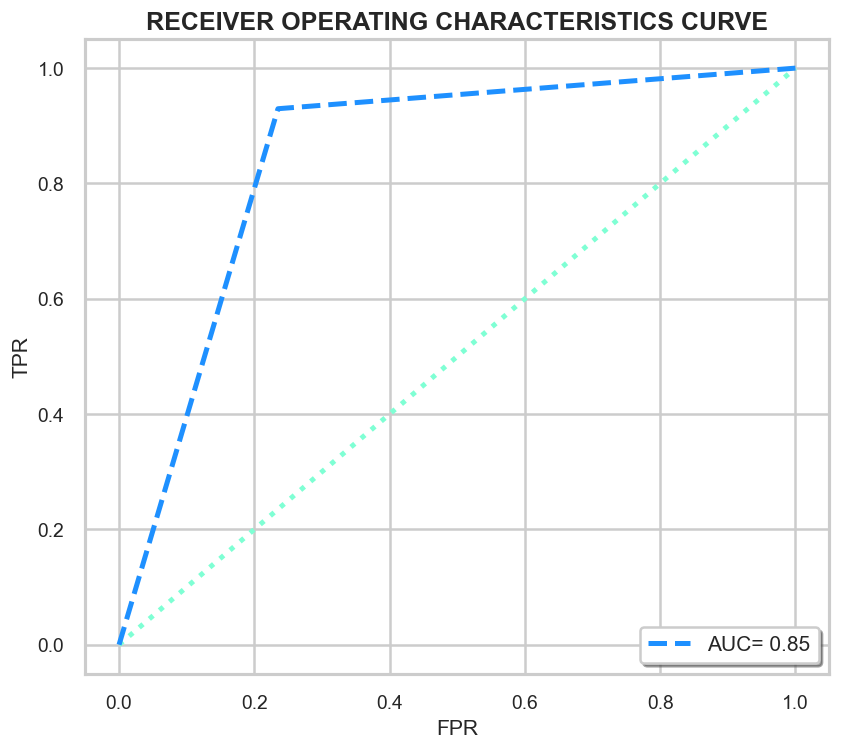

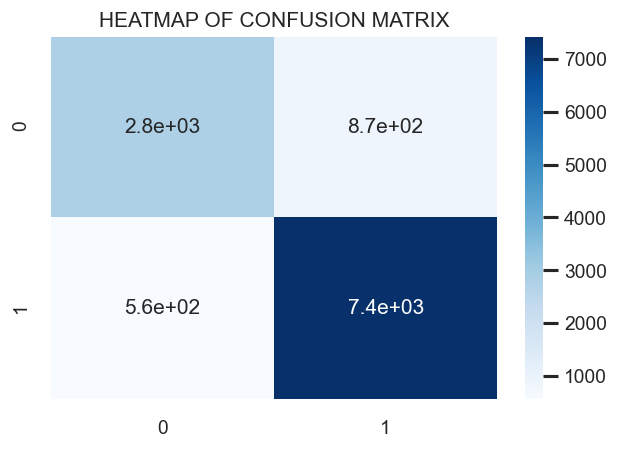

In [32]:
svc=SVC(kernel='linear',gamma=0.1,degree=9)
acusr(svc,x,y)

**RANDOM FOREST CLASSIFIER**

In [34]:
rfc=RandomForestClassifier()
rfc_para={"n_estimators":[200,350],'max_depth':[6,9],'criterion':('gini','entropy')}
rfc_gsv=gsv(rfc,rfc_para,cv=50)
rfc_gsv.fit(x,y)
print(rfc_gsv)
print('\nbest score=',rfc_gsv.best_score_)
print('\nbest parameters for RFC=\n',rfc_gsv.best_params_)

GridSearchCV(cv=50, estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'), 'max_depth': [6, 9],
                         'n_estimators': [200, 350]})

best score= 0.6903579501767146

best parameters for RFC=
 {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 200}


In this RandomForestClassifier(max_depth=9, n_estimators=200) 
RANDOM STATE:
 72

ACCURACY SCORE:
 0.7004280821917809

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.03      0.06      3699
           1       0.69      1.00      0.82      7981

    accuracy                           0.69     11680
   macro avg       0.84      0.51      0.44     11680
weighted avg       0.79      0.69      0.58     11680


CONFUSION MATRIX:
 [[ 108 3591]
 [   0 7981]]

PRECISION:
 0.6896819910127895

RECALL:
 1.0

MEAN SQUARED ERROR:
 0.3074486301369863

ROOT MEAN SQ. ERROR:
 0.5544805047402355


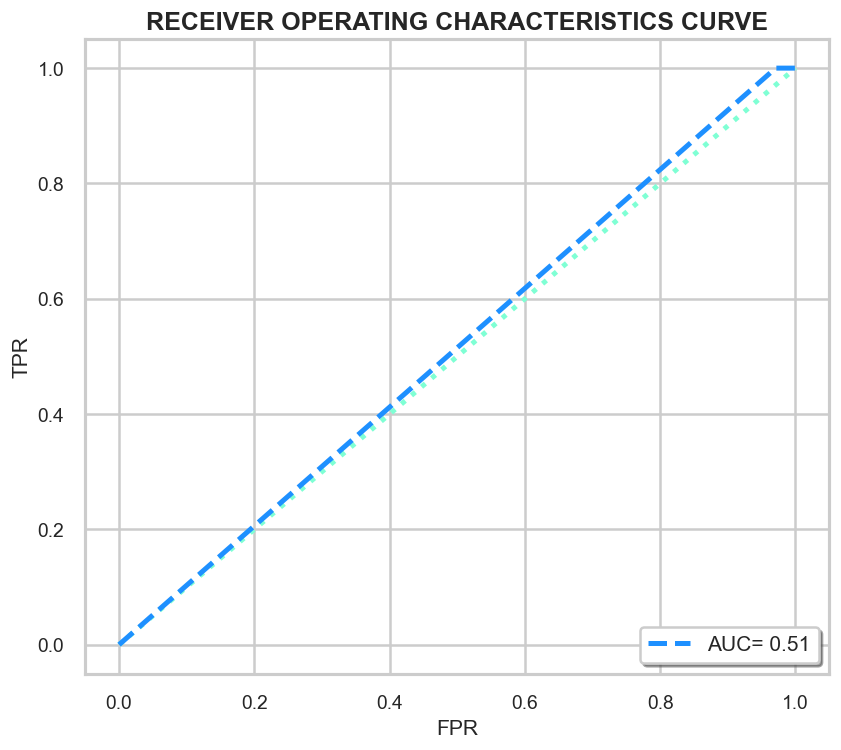

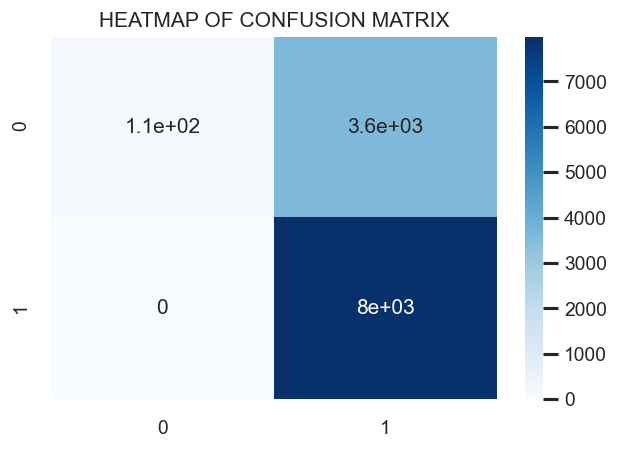

In [35]:
rfc=RandomForestClassifier(n_estimators=200,max_depth=9,criterion='gini')
acusr(rfc,x,y)

**RESULTS**

In [36]:
model=["LOGISTIC",'MNB','CNB','SVC','RANDOM FOREST']
results = pd.DataFrame({"MODEL":model,'Accuracy':ACCURACY,'Precision': PRECISION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,"ROC_AUC":ROC_AUC})
                               
                                
            
results.style.set_properties(**{'background-color':'darkslategrey','color': 'springgreen','border-color': 'darkorange'})                                   

,MODEL,Accuracy,Precision,Recall,RMSE,MSE,ROC_AUC
0,LOGISTIC,0.880308,0.889296,0.942113,0.345965,0.119692,0.844536
1,MNB,0.859332,0.858484,0.950883,0.375057,0.140668,0.806342
2,CNB,0.853510,0.845721,0.960907,0.382740,0.146490,0.791348
3,SVC,0.877483,0.895150,0.929583,0.350024,0.122517,0.847327
4,RANDOM FOREST,0.692551,0.689682,1.000000,0.554481,0.307449,0.514599


**SAVING THE MODEL**

In [37]:
logi

LogisticRegression(max_iter=600, warm_start=True)

In [38]:
import joblib
joblib.dump(logi,'HOTEL_LOGI.pkl')

['HOTEL_LOGI.pkl']

**LOADING THE SAVED MODEL & PREDICTING THE TEST DATASET**

In [39]:
hotel_sentiment=joblib.load("HOTEL_LOGI.pkl")

In [40]:
#importing test file
test=pd.read_csv(r"C:\Users\mishr\fr_projects\hotel\test.csv")
test.head(5)

,User_ID,Description,Browser_Used,Device_Used
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile


In [41]:
test.shape

(29404, 4)

In [42]:
#DROPPING UNWANTED
test.drop(['User_ID','Browser_Used','Device_Used'],axis=1,inplace=True)#

In [43]:
#CREATING A COLUMN TO CHECK THE LENGTH OF EACH ROW OF DESCRIPTION COLUMN
test['len_uncleaned desc']=test['Description'].str.len()
test.head(3)

,Description,len_uncleaned desc
0,Looking for a motel in close proximity to TV t...,676
1,Walking distance to Madison Square Garden and ...,588
2,Visited Seattle on business. Spent - nights in...,863


In [44]:
#CONVRTING EVERYTHING TO LOWERCASE
test['Description']=test['Description'].str.lower()

#REPLACING NEXT LINES BY WHITE SPACE
test['Description']=test['Description'].str.replace(r'\n'," ") 

#REPLACING SPECIAL CHARACTERS AND NUMBERS BY WHITE SPACE IT ALSO REMOVES THE PUNCTUATIONS
test['Description']=test['Description'].str.replace(r"[^a-zA-Z]+", " ") #removing all special characters

In [45]:
#PREVIEW AFTER LOWER CASE CONVERSION AND REMOVAL OF UNWANTED CHARACTERS
print(test['Description'][2:8])

2    visited seattle on business spent nights in th...
3    this hotel location is excellent and the rooms...
4    this hotel is awesome i love the service antho...
5    rooms concierge services and party scene were ...
6    what a pleasant place to stay the hotel is bea...
7    i booked out the same day i arrived it cost me...
Name: Description, dtype: object


In [46]:
%%time
cleaned_test = []

for i in test['Description']:
    cleaned_test.append(clean(i))

Wall time: 30min 45s


In [47]:
#ADDING THE EXTRACTED FEATURES TO THE DATAFRAME



#creating a dataframe with a variable name 'processed'
processed = pd.DataFrame({'cleaned_description':cleaned_test})  

 #concatenating test and processed dataframe
test = pd.concat([test, processed], axis = 1) 


#creating a new column containing length of cleaned description
test['len_cleaned_description']=test['cleaned_description'].str.len() 
test.sample(5)

,Description,len_uncleaned desc,cleaned_description,len_cleaned_description
2349,went there for vacation prior to a conference ...,416,go vacation prior conference spouse love lobby...,263
6671,i have often relied upon tripadvisor reviews h...,1497,often rely upon tripadvisor review however one...,898
7551,my boyfriend and i stayed in the san carlos ho...,2390,boyfriend stay san carlos hotel december janua...,1386
7609,this hotel was magic from the moment we walked...,680,hotel magic moment walk door modern decor loca...,384
22586,we have stayed here or times and are returning...,498,stay time return year room large clean locatio...,320


In [58]:
x_tr=tfidf(input='content', encoding='utf-8', lowercase=True,stop_words='english').fit(train['cleaned_description'])

In [59]:
x_tst=x_tr.transform(test['cleaned_description'])
x_tst

<29404x38774 sparse matrix of type '<class 'numpy.float64'>'
	with 1601014 stored elements in Compressed Sparse Row format>

In [61]:
predict=hotel_sentiment.predict(x_tst)
predict

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

In [63]:
#saving the result to csv
np.savetxt('hotel_sentiment.csv', predict, delimiter=',', fmt='%d')